In [ ]:
import os
import shapely
import numpy as np
import sys 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.geometric_utils import geojson2shpfile


def save_geometry(dataframe,geometry,out_path,fname='dataframe.geojson'):
    df_to_save = gpd.GeoDataFrame(geometry=dataframe[geometry],crs="EPSG:4326")
    df_to_save = df_to_save.to_crs("epsg:4326")
    df_to_save.to_file(os.path.join(out_path,fname),driver="GeoJSON")

In [ ]:
# geojson2shpfile('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/California/California.geojson',verbose=0)

## Los Angeles

In [ ]:
from os.path import isfile

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "California"
city = "LosAngles"
apt_data_path = os.path.join(data_path,state,"APT_2022_09_000_nam_usa_uca.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_06037/Parcels_06037.shp")
building_geojson = os.path.join(data_path,state,'California.geojson')

In [ ]:
if os.path.isfile(apt_data_path) and os.path.isfile(parcel_path) and os.path.isfile(building_geojson): 
    apt_preprocess = ProcessAPT_data(
                        parcel_shapefile=parcel_path,
                        building_shapefile=building_geojson,
                        apt_shape_file=apt_data_path,
                        output_path = os.path.join(data_path,state,city,'Apt_realignment') 
                        )
    processed_df_LA = apt_preprocess.process_dataframe(bfp_count_per_parcel=2,filename='APT_realigned_usa_uca_LA')
print("Data Shape:",processed_df_LA.shape)


In [ ]:
processed_df_LA.head()

In [ ]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

# processed_df_LA['APT_to_Centroid_distance'] = processed_df_LA.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)
processed_df_LA.head(4)

In [ ]:
distance_greater_than_50m = processed_df_LA.loc[processed_df_LA['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_LA['APT_to_Centroid_distance'].loc[processed_df_LA['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_LA['APT_to_Centroid_distance'].loc[processed_df_LA['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df_LA.shape[0])))

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_LA['APT_to_Centroid_distance'].loc[processed_df_LA['APT_to_Centroid_distance']<50].values, bins = np.arange(5,55,15))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
def save_geometry(dataframe,geometry,out_path,fname='dataframe.geojson'):
    df_to_save = gpd.GeoDataFrame(geometry=dataframe[geometry],crs="EPSG:4326")
    df_to_save = df_to_save.to_crs("epsg:4326")
    df_to_save.to_file(os.path.join(out_path,fname),driver="GeoJSON")

out_path = os.path.join(data_path,state,city,"Apt_realignment/APT_realign_2_bfp2parcel")
filename = os.path.join(out_path,'2022_06_012_nam_usa_uca_bfp.geojson')
save_geometry(processed_df_LA,'building_roi',out_path=out_path,fname=filename)

## Santa Clara California 

In [ ]:
data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "California"
city = "SantaClara"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_012_nam_usa_uca.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_06085/Parcels_06085.shp")
building_geojson = os.path.join(data_path,state,'California.geojson')

### Read APT data From MNR Database 

In [ ]:
apt_df = gpd.read_file(apt_data_path)
apt_df = gpd.GeoDataFrame(apt_df,crs="EPSG:4326",geometry='geometry')
apt_df = apt_df.to_crs("epsg:4326")
print("Total number of data points collected from MNR database ",apt_df.shape[0])
gc.collect()
apt_df.head()

# sns.countplot(apt_df['AnchorPoin'])
# print(apt_df['AnchorPoin'].value_counts())

# print("Building Address Points :{}".format(apt_df['AnchorPoin'].value_counts()[0] /apt_df['AnchorPoin'].count()))
# print("Address Parcel  Centroid Points:{}".format(apt_df['AnchorPoin'].value_counts()[1] /apt_df['AnchorPoin'].count() ))

### Read State Building Footprint Data

In [ ]:
# # Read MIcrosoft data 
# print("reading :",os.path.basename(building_geojson))
# footprint_df = gpd.read_file(building_geojson)
# footprint_df = gpd.GeoDataFrame(footprint_df, crs="EPSG:4326", geometry='geometry')
# print("Building CRS:",footprint_df.crs)

# gc.collect()
# footprint_df.head()

### Read Parcel Data specific to County

In [ ]:
# read Parcel data
parcel_df = gpd.read_file(parcel_path)
parcel_df = gpd.GeoDataFrame(parcel_df,crs="EPSG:4326",geometry='geometry')
# convert parcel crs to same as building fooprint
parcel_df = parcel_df.to_crs("epsg:4326")
parcel_polygon_changedcrs_df = gpd.GeoDataFrame(geometry=parcel_df['geometry'])

print("CRS after conversion: ",parcel_df.crs)
print("Parcel Data Points :",parcel_df.shape[0])
# parcel_polygon_changedcrs_df.to_file(os.path.join(out_path,"parcel_DistrictofColumbia.geojson"), driver="GeoJSON")
gc.collect()

parcel_df.head(10)

### Process Data 

In [ ]:
apt_preprocess = ProcessAPT_data(
                    parcel_shapefile=parcel_path,
                    building_shapefile=building_geojson,
                    apt_shape_file=apt_data_path,
                    output_path = os.path.join(data_path,state,city,'Apt_realignment') 
                    )

processed_df_ca = apt_preprocess.process_dataframe(bfp_count_per_parcel=1,filename='APT_realigned_uca_santaClara')
print("Data Shape:",processed_df_ca.shape)

In [ ]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_ca['APT_to_Centroid_distance'] = processed_df_ca.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

# processed_df_ca['APT_lat'] = processed_df_ca['APT'].apply(lambda z: z.y)
# processed_df_ca['APT_lon'] = processed_df_ca['APT'].apply(lambda z: z.x)

# processed_df_ca['updated_lat'] = processed_df['updated_geometries'].apply(lambda z: z.y)
# processed_df['updated_lon'] = processed_df['updated_geometries'].apply(lambda z: z.x)
processed_df_ca.head()

In [ ]:
# out_path = os.path.join(data_path,city)
# save_geometry(processed_df,geometry='updated_geometries',out_path=out_path,fname='APT_usa_uca_updated_gemotries.geojson')
# save_geometry(processed_df,geometry='APT',out_path=out_path,fname='APT_usa_uca.geojson')
# save_geometry(processed_df,geometry='building_geometry',out_path=out_path,fname='building_roi_usa_ua.geojson')

In [ ]:
distance_greater_than_50m = processed_df_ca.loc[processed_df_ca['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_ca['APT_to_Centroid_distance'].loc[processed_df_ca['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_ca['APT_to_Centroid_distance'].loc[processed_df_ca['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df_ca.shape[0])))

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_ca['APT_to_Centroid_distance'].loc[processed_df_ca['APT_to_Centroid_distance']>50].values, bins = np.arange(45,500,15))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_ca['APT_to_Centroid_distance'].loc[processed_df_ca['APT_to_Centroid_distance']<50].values, bins = np.arange(5,50,10))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
import os.path as osp
def save_geometry(dataframe,geometry,out_path,fname='dataframe.geojson'):
    df_to_save = gpd.GeoDataFrame(geometry=dataframe[geometry],crs="EPSG:4326")
    df_to_save = df_to_save.to_crs("epsg:4326")
    df_to_save.to_file(os.path.join(out_path,fname),driver="GeoJSON")

out_path = osp.join(data_path,state,city,"Apt_realignment/APT_realign_2_bfp2parcel")
filename = os.path.join(out_path,'usa_uca_santa_calra_bfp.geojson')
save_geometry(processed_df_ca,'building_roi',out_path=out_path,fname=filename)


## Araphoe Colarado  

In [ ]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment/utils')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.extract_mnr_data import ExtractMNRData as extract_mnr_data

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Colorado"
city = "Arapahoe"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_012_nam_usa_uco.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_08005/Parcels_08005.shp")
building_geojson = os.path.join(data_path,state,'Colorado.geojson')

In [ ]:
# if os.path.isfile(parcel_path):
#     mnr_database = extract_mnr_data(country_code='_2022_06_010_nam_usa_uco')
#     mnr_database.connect_to_server()
#     # out_path = os.path.join(data_path,state)
#     # mnr_apt_df = mnr_database.extract_apt_addresses_data()
#     # mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_009_nam_usa_uco.shp')

gc.collect()

In [ ]:
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,apt_shape_file=apt_data_path)
processed_df_co = apt_preprocess.process_dataframe(bfp_count_per_parcel=1)
processed_df_co.head(10)

In [ ]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_co['APT_to_Centroid_distance'] = processed_df_co.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)
processed_df_co['APT_lat'] = processed_df_co['APT'].apply(lambda z: z.y)
processed_df_co['APT_lon'] = processed_df_co['APT'].apply(lambda z: z.x)

processed_df_co['updated_lat'] = processed_df_co['updated_geometries'].apply(lambda z: z.y)
processed_df_co['updated_lon'] = processed_df_co['updated_geometries'].apply(lambda z: z.x)
processed_df_co.head()

In [ ]:
distance_greater_than_50m = processed_df_co.loc[processed_df_co['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_co['APT_to_Centroid_distance'].loc[processed_df_co['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_co['APT_to_Centroid_distance'].loc[processed_df_co['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df_co.shape[0])))

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_co['APT_to_Centroid_distance'].loc[processed_df_co['APT_to_Centroid_distance']>50].values, bins = np.arange(45,max_dist,15))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_co['APT_to_Centroid_distance'].loc[processed_df_co['APT_to_Centroid_distance']<50].values, bins = np.arange(5,50,10))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
df_for_analysis_usa_co_arapahoe = processed_df_co.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_co_arapahoe.head()

## Miamidade_Florida

In [ ]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment/utils')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.extract_mnr_data import ExtractMNRData as extract_mnr_data


data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Florida"
city = "Miamidade"

apt_data_path = os.path.join(data_path,state,"APT_2022_06_012_nam_usa_ufl.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_12086/Parcels_12086.shp")
building_geojson = os.path.join(data_path,state,'Florida.geojson')

In [ ]:
if not os.path.isfile(apt_data_path):
    mnr_database = extract_mnr_data(country_code='_2022_06_009_nam_usa_ufl')
    mnr_database.connect_to_server()
    # out_path = os.path.join(data_path,state)
    # mnr_apt_df = mnr_database.extract_apt_addresses_data()
    # mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_009_nam_usa_ufl.shp')

In [ ]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 

apt_preprocess = ProcessAPT_data(
    parcel_shapefile=parcel_path,
    building_shapefile=building_geojson,
    apt_shape_file=apt_data_path,
    output_path=output_path
    )

processed_df_miamidade = apt_preprocess.process_dataframe(bfp_count_per_parcel=1,filename='APT_realigned_usa_ufl_miamidade')

In [ ]:
processed_df_miamidade.head(4)

In [ ]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_miamidade['APT_to_Centroid_distance'] = processed_df_miamidade.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)
processed_df_miamidade['APT_lat'] = processed_df_miamidade['APT'].apply(lambda z: z.y)
processed_df_miamidade['APT_long'] = processed_df_miamidade['APT'].apply(lambda z: z.x)

processed_df_miamidade['updated_lat'] = processed_df_miamidade['updated_geometries'].apply(lambda z: z.y)
processed_df_miamidade['updated_lon'] = processed_df_miamidade['updated_geometries'].apply(lambda z: z.x)
processed_df_miamidade.head()

In [ ]:
distance_greater_than_50m = processed_df_miamidade.loc[processed_df_miamidade['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_miamidade['APT_to_Centroid_distance'].loc[processed_df_miamidade['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_miamidade['APT_to_Centroid_distance'].loc[processed_df_miamidade['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}% ".format(100*(distance_greater_than_50m/processed_df_miamidade.shape[0])))

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_miamidade['APT_to_Centroid_distance'].loc[processed_df_miamidade['APT_to_Centroid_distance']>=50].values, bins = np.arange(45,max_dist,15))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points Disstance from Building Centroid',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_miamidade['APT_to_Centroid_distance'].loc[processed_df_miamidade['APT_to_Centroid_distance']<50].values, bins = np.arange(0,50,10))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points Disstance from Building Centroid',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
df_for_analysis_usa_fl = processed_df_miamidade.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_fl.head()

In [ ]:
# output_path = os.path.join(data_path,state,city,'Apt_realignment/01_apt_realignment_mapping')
# print(output_path)
# os.makedirs(output_path,exist_ok=True)

# filename = os.path.join(output_path,'APT_realigned_usa_ufl_miamidade')
# geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_fl, geometry='updated_geometries', crs="EPSG:4326")
# pd_dataframe = pd.DataFrame(geo_dataframe)

# pd_dataframe.to_pickle(filename+".pkl")
# geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename+".shp")


## Duval_Florida

In [ ]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/"
state = "Florida"
city = "Duval"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_012_nam_usa_ufl.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_12031/Parcels_12031.shp")
building_geojson = os.path.join(data_path,state,'Florida.geojson')

In [ ]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 

apt_preprocess = ProcessAPT_data(
                        parcel_shapefile=parcel_path,
                        building_shapefile=building_geojson,
                        apt_shape_file=apt_data_path,output_path=output_path
                        )

processed_df_duval = apt_preprocess.process_dataframe(bfp_count_per_parcel=1,filename='APT_realigned_nam_usa_ufl_duval')
processed_df_duval.head(4)

In [ ]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_duval['APT_to_Centroid_distance'] = processed_df_duval.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

processed_df_duval['APT_lat'] = processed_df_duval['APT'].apply(lambda z: z.y)
processed_df_duval['APT_long'] = processed_df_duval['APT'].apply(lambda z: z.x)

processed_df_duval['updated_lat'] = processed_df_duval['updated_geometries'].apply(lambda z: z.y)
processed_df_duval['updated_long'] = processed_df_duval['updated_geometries'].apply(lambda z: z.x)

processed_df_duval.head()

In [ ]:
distance_greater_than_50m = processed_df_duval.loc[processed_df_duval['APT_to_Centroid_distance']>50].shape[0]
max_dist = processed_df_duval['APT_to_Centroid_distance'].loc[processed_df_duval['APT_to_Centroid_distance']>50].max()
print("Max distance APT from Parcel to Building Centroid {:.2f} m".format(processed_df_duval['APT_to_Centroid_distance'].loc[processed_df_duval['APT_to_Centroid_distance']>50].max()))
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_duval.shape[0])))

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_duval['APT_to_Centroid_distance'].loc[processed_df_duval['APT_to_Centroid_distance']>=50].values, bins = np.arange(45,max_dist,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points Distance',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_duval['APT_to_Centroid_distance'].loc[processed_df_duval['APT_to_Centroid_distance']<50].values, bins = np.arange(0,50,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points Distance',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
df_for_analysis_usa_duval = processed_df_duval.drop(['APN','FIPS','PRCLDMPID','geometry','building_geometry','building_roi','APT'],axis=1)
df_for_analysis_usa_duval.head()

In [ ]:
# output_path = os.path.join(data_path,state,city,'Apt_realignment/01_apt_realignment_mapping') 
# os.makedirs(output_path,exist_ok=True)

# geo_dataframe = gpd.GeoDataFrame(df_for_analysis_usa_duval, geometry='updated_geometries', crs="EPSG:4326")
# pd_dataframe = pd.DataFrame(geo_dataframe)
# filename = os.path.join(output_path,'APT_realigned_2022_06_009_nam_usa_ufl_duval')

# pd_dataframe.to_pickle(filename+'.pkl')
# geo_dataframe.to_file(driver='ESRI Shapefile', filename=filename+'.shp')


## Harris Texas

In [ ]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Texas"
city = "Harris"
apt_data_path = os.path.join(data_path,state,"APT_2022_06_012_nam_usa_utx.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_48201/Parcels_48201.shp")
building_geojson = os.path.join(data_path,state,'Texas.geojson')

In [ ]:
geojson_path = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Texas/Texas"
if not os.path.isfile(geojson_path+'.shp'):
    geojson2shpfile(geojson_path+'.geojson',verbose=0)

In [ ]:
if not os.path.isfile(apt_data_path):
    print("downloading .. ")
    mnr_database = extract_mnr_data(country_code='_2022_06_009_nam_usa_ugx')
    mnr_database.connect_to_server()

    out_path = os.path.join(data_path,state)
    # mnr_apt_df = mnr_database.extract_apt_addresses_data()
    # mnr_database.save_dataframe_as_shpfile(mnr_apt_df, out_path, filename='APT_2022_06_009_nam_usa_ugx.shp')

In [ ]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,
                building_shapefile=building_geojson,
                apt_shape_file=apt_data_path , 
                output_path=output_path)

if not os.path.isfile(os.path.join(output_path,'APT_realigned_usa_utx_Harris.pkl')):
    processed_df_harris = apt_preprocess.process_dataframe(bfp_count_per_parcel=1,filename='APT_realigned_usa_utx_Harris')
    processed_df_harris.head(10)

In [ ]:
processed_df = pd.read_pickle(os.path.join(output_path,'APT_realign_1_bfp2parcel/APT_realigned_usa_utx_Harris.pkl'))
processed_df.head()

In [ ]:
def get_apt_to_bfp_distance(data):
    anchor_point = data['APT']
    bfp_centroid = data['updated_geometries']
    return get_distance(anchor_point, bfp_centroid)

processed_df_harris['APT_to_Centroid_distance'] = processed_df_harris.apply(lambda x: get_apt_to_bfp_distance(x),axis=1)

# processed_df_harris['APT_lat'] = processed_df_harris['APT'].apply(lambda z: z.y)
# processed_df_harris['APT_lon'] = processed_df_harris['APT'].apply(lambda z: z.x)

# processed_df_harris['updated_lat'] = processed_df_harris['updated_geometries'].apply(lambda z: z.y)
# processed_df_harris['updated_lon'] = processed_df_harris['updated_geometries'].apply(lambda z: z.x)

processed_df_harris.head()

In [ ]:
distance_greater_than_50m = processed_df_harris.loc[processed_df_harris['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_harris.shape[0])))

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_harris['APT_to_Centroid_distance'].loc[processed_df_harris['APT_to_Centroid_distance']>50].values, bins = np.arange(45,250,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

In [ ]:
print(processed_df_harris.shape)
processed_df_harris[['updated_geometries','feat_id','postal_cod','house_numb','state_prov','locality','street_nam','country_co','prefix','suffix',
	                'predir','postdir','sn_body','APT_to_Centroid_distance','APT_lat','APT_lon','updated_lat',	'updated_lon']].head()

## Los Angles California

In [ ]:
import os
import shapely
import numpy as np
import sys 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.geometric_utils import geojson2shpfile


def save_geometry(dataframe,geometry,out_path,fname='dataframe.geojson'):
    df_to_save = gpd.GeoDataFrame(geometry=dataframe[geometry],crs="EPSG:4326")
    df_to_save = df_to_save.to_crs("epsg:4326")
    df_to_save.to_file(os.path.join(out_path,fname),driver="GeoJSON")

In [ ]:
from os.path import isfile

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "California"
city = "LosAngles"
apt_data_path = os.path.join(data_path,state,"APT_2022_09_000_nam_usa_uca.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_06037/Parcels_06037.shp")
building_geojson = os.path.join(data_path,state,'California.geojson')

### Single BFP to Parcel match 

In [ ]:
apt_preprocess = ProcessAPT_data(
    parcel_shapefile=parcel_path,
    building_shapefile=building_geojson,
    apt_shape_file=apt_data_path,
    output_path = os.path.join(data_path,state,city,'Apt_realignment')
    )

processed_df_LA = apt_preprocess.process_dataframe(bfp_count_per_parcel=1,filename='APT_realigned_usa_uca_LA')

In [ ]:
print("Data Shape:",processed_df_LA.shape)
processed_df_LA.head(4)

In [ ]:
distance_greater_than_50m = processed_df_LA.loc[processed_df_LA['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_LA.shape[0])))

distance_greater_than_50m = processed_df_LA.loc[processed_df_LA['APT_to_Centroid_distance']<50].shape[0]
print("Data points Less than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_LA.shape[0])))

### Two BFP's within Parcel

In [ ]:
apt_preprocess = ProcessAPT_data(
    parcel_shapefile=parcel_path,
    building_shapefile=building_geojson,
    apt_shape_file=apt_data_path,
    output_path = os.path.join(data_path,state,city,'Apt_realignment')
    )

processed_df_LA = apt_preprocess.process_dataframe(bfp_count_per_parcel=2,filename='APT_realigned_usa_uca_LA')

In [ ]:
print("Data Shape:",processed_df_LA.shape)
processed_df_LA.head(4)

In [ ]:
distance_greater_than_50m = processed_df_LA.loc[processed_df_LA['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_LA.shape[0])))

distance_greater_than_50m = processed_df_LA.loc[processed_df_LA['APT_to_Centroid_distance']<50].shape[0]
print("Data points Less than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_LA.shape[0])))

## Bexar Texas 

In [1]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Texas"
city = "Bexar"
apt_data_path = os.path.join(data_path,state,"APT_2022_09_000_nam_usa_utx.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_48029/Parcels_48029.shp")
building_geojson = os.path.join(data_path,state,'Texas.geojson')

/home/tandon/anaconda3/envs/pygeo/lib/python3.8/site-packages/geopandas/_compat.py:112: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Single BFP within a Parcel 

In [2]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,
                building_shapefile=building_geojson,
                apt_shape_file=apt_data_path , 
                output_path=output_path)

processed_df_bexar = apt_preprocess.process_dataframe(bfp_count_per_parcel=1,filename='APT_realigned_usa_utx_bexar')

2022-09-05 20:21:14,393:INFO:- Processing APT's with 1 BFP-Count Per Parcel
2022-09-05 20:21:14,394:INFO:- Reading Land Parcel data and Building Footprints 
2022-09-05 20:29:18,388:INFO:- creating sjoin of land Parcel data and Building Footprints 


In [ ]:
print("Data shape",processed_df_bexar.shape[0])
processed_df_bexar.head(4)

In [ ]:
distance_greater_than_50m = processed_df_bexar.loc[processed_df_bexar['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_bexar.shape[0])))

distance_greater_than_50m = processed_df_bexar.loc[processed_df_bexar['APT_to_Centroid_distance']<50].shape[0]
print("Data points Less than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_bexar.shape[0])))

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_bexar['APT_to_Centroid_distance'].loc[processed_df_bexar['APT_to_Centroid_distance']<150].values, bins = np.arange(0,150,10))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

### Two BFP within a Parcel 

In [ ]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,
                building_shapefile=building_geojson,
                apt_shape_file=apt_data_path , 
                output_path=output_path)

processed_df_bexar = apt_preprocess.process_dataframe(bfp_count_per_parcel=2,filename='APT_realigned_usa_utx_bexar')

In [ ]:
print(processed_df_bexar.shape[0])
processed_df_bexar.head(10)

In [ ]:
distance_greater_than_50m = processed_df_bexar.loc[processed_df_bexar['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_bexar.shape[0])))

distance_greater_than_50m = processed_df_bexar.loc[processed_df_bexar['APT_to_Centroid_distance']<50].shape[0]
print("Data points less than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_bexar.shape[0])))

In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_bexar['APT_to_Centroid_distance'].loc[processed_df_bexar['APT_to_Centroid_distance']<150].values, bins = np.arange(0,150,10))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

### Merge data

In [ ]:
from glob import glob 
pkl_path = osp.join(data_path,state,city,'Apt_realignment')
pkl_files = glob(pkl_path+'/*/*.pkl')
print(pkl_files)

In [ ]:

## Show single bfp within Parcel data
df_one_bfp = pd.read_pickle(pkl_files[0])
df_one_bfp = df_one_bfp.reset_index(drop=True)
print("simple scenario sahpe",df_one_bfp.shape[0])

df_two_bfp = pd.read_pickle(pkl_files[1])
df_two_bfp = df_two_bfp.reset_index(drop=True)
print(" complx scenario shape:",df_two_bfp.shape[0])

merge_df= pd.concat([df_one_bfp,df_two_bfp])
print("Merged Shape",merge_df.shape)
merge_df.to_pickle(os.path.join(pkl_path,'FinalUpdated_APT_{}_{}.pkl'.format(state,city)))

## IIlunois Cook

In [19]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance
from utils.geometric_utils import geojson2shpfile

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Illinois"
city = "cook"
apt_data_path = os.path.join(data_path,state,"APT__2022_09_001_nam_usa_uil.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_17031/Parcels_17031.shp")
building_geojson = os.path.join(data_path,state,'Illinois.geojson')

In [2]:
# geojson2shpfile(building_geojson,verbose=0)

### Single BFP within a Parcel 

In [3]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,
                building_shapefile=building_geojson,
                apt_shape_file=apt_data_path , 
                output_path=output_path)

processed_df_cook = apt_preprocess.process_dataframe(bfp_count_per_parcel=1,filename='APT_realigned_usa_il_cook')


2022-09-02 14:48:16,065:INFO:- Processing APT's with 1 BFP-Count Per Parcel
2022-09-02 14:48:16,066:INFO:- Processing Land Parcel data and Building Footprints 
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -87.756268696715026 42.061860287983436 at -87.756268696715026 42.061860287983436
ERROR:root:error for POLYGON ((-87.756596 42.061351, -87.756489 42.061352, -87.756489 42.061325, -87.756344 42.061326, -87.756344 42.061346, -87.756237 42.061347, -87.756238 42.061412, -87.756181 42.061413, -87.75618299999999 42.061527, -87.75622799999999 42.061527, -87.756229 42.061587, -87.756167 42.061587, -87.75617099999999 42.061755, -87.756289 42.061753, -87.75629000000001 42.061803, -87.756336 42.061802, -87.756336 42.061836, -87.75622799999999 42.061837, -87.756231 42.061984, -87.756331 42.061982, -87.756332 42.062011, -87.75650400000001 42.062009, -87.756503 42.061982, -87.756597 42.061981, -87.756591 42.06172, -87.75670599999999 42.061718, -87.756705 42.061

In [4]:
print(processed_df_cook.shape[0])
processed_df_cook.head(4)

709024


,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,feat_id,iso_script,iso_lang_c,postal_cod,...,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT,updated_geometries,APT_to_Centroid_distance
2,01011110110000,17031,100660192_202277880,"POLYGON ((-88.13279 42.15191, -88.13303 42.151...","POLYGON ((-88.13300599999999 42.152041, -88.13...","POLYGON ((-88.13301 42.15204, -88.13285 42.152...",00005549-3100-2800-0000-000000004feb,Latn,ENG,60010,...,E Lake St,USA,None,St,E,None,Lake,POINT (-88.132863 42.152048),POINT (-88.13292 42.15211),8.5
3,01011110100000,17031,100660192_202277881,"POLYGON ((-88.13256 42.15191, -88.13279 42.151...","POLYGON ((-88.132592 42.152236, -88.132729 42....","POLYGON ((-88.13259 42.15224, -88.13273 42.152...",00005549-3100-2800-0000-000000004fec,Latn,ENG,60010,...,E Lake St,USA,None,St,E,None,Lake,POINT (-88.132614 42.152045),POINT (-88.13266 42.15212),8.8
5,01011100110000,17031,100660192_202277873,"POLYGON ((-88.13425 42.15157, -88.13475 42.151...","POLYGON ((-88.13442999999999 42.151587, -88.13...","POLYGON ((-88.13443 42.15159, -88.13443 42.151...",00005549-3100-2800-0000-000000004fa2,Latn,ENG,60010,...,S Cook St,USA,None,St,S,None,Cook,POINT (-88.134426 42.151649),POINT (-88.13456 42.15162),11.7
7,01011100060000,17031,100660192_202277871,"POLYGON ((-88.13377 42.15174, -88.13425 42.151...","POLYGON ((-88.13397000000001 42.151805, -88.13...","POLYGON ((-88.13397 42.15181, -88.13397 42.151...",00005549-3100-2800-0000-000000004fa8,Latn,ENG,60010,...,S Grove Ave,USA,None,Ave,S,None,Grove,POINT (-88.13393600000001 42.1518),POINT (-88.13393 42.15184),4.1


In [5]:
distance_greater_than_50m = processed_df_cook.loc[processed_df_cook['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_cook.shape[0])))

distance_greater_than_50m = processed_df_cook.loc[processed_df_cook['APT_to_Centroid_distance']<50].shape[0]
print("Data points less than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_cook.shape[0])))


Data points greater than 50m: 1.03%
Data points less than 50m: 98.97%


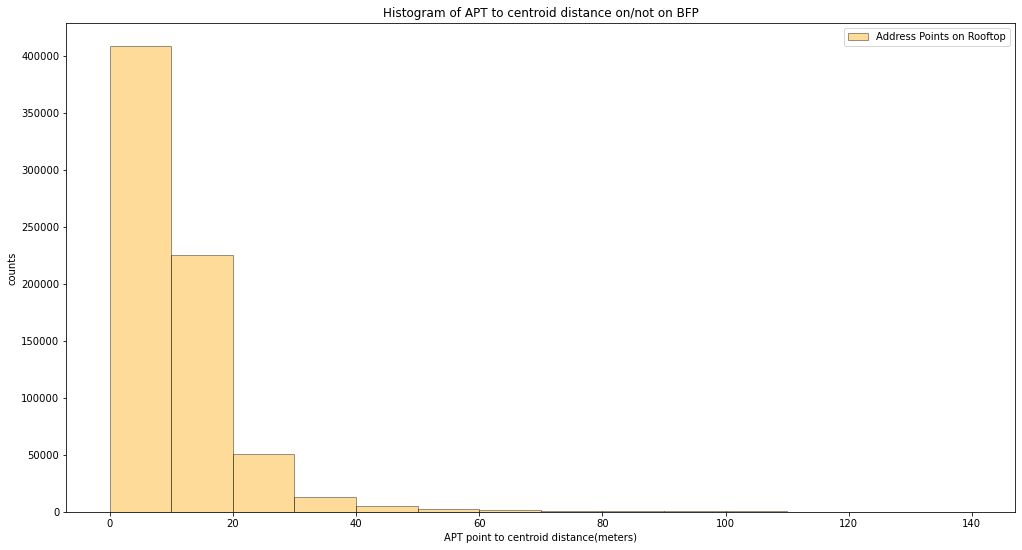

21

In [6]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_cook['APT_to_Centroid_distance'].loc[processed_df_cook['APT_to_Centroid_distance']<150].values, bins = np.arange(0,150,10))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

#### Two BFP's within a Parcel 

In [ ]:
## Process complexity 2-- 2 bfp 

output_path = os.path.join(data_path,state,city,'Apt_realignment') 
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,
                building_shapefile=building_geojson,
                apt_shape_file=apt_data_path , 
                output_path=output_path)

processed_df_cook = apt_preprocess.process_dataframe(bfp_count_per_parcel=2,filename='APT_realigned_usa_uil_cook')

In [8]:
print(processed_df_cook.shape[0])
processed_df_cook.head(4)

377673


,PRCLDMPID,building_roi,APT,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,geometry,updated_geometries,APT_to_Centroid_distance
0,100660192_202272334,"POLYGON ((-88.253107 42.065834, -88.253276 42....",POINT (-88.253221 42.065828),00005549-3100-2800-0000-0000000aab23,Latn,ENG,60120,1006,IL,Elgin,Huron Dr,USA,None,Dr,None,None,Huron,"POLYGON ((-88.25329 42.06568, -88.25330 42.065...",POINT (-88.2531915 42.06578900000001),4.9
1,100660192_202272341,"POLYGON ((-88.25142200000001 42.065662, -88.25...",POINT (-88.25133700000001 42.065737),00005549-3100-2800-0000-0000000aabe1,Latn,ENG,60120,1050,IL,Elgin,Huron Dr,USA,None,Dr,None,None,Huron,"POLYGON ((-88.25133 42.06552, -88.25139 42.065...",POINT (-88.25136832109457 42.06571976955762),3.2
2,100660192_202272343,"POLYGON ((-88.25058 42.065715, -88.250512 42.0...",POINT (-88.250683 42.065729),00005549-3100-2800-0000-0000000aabe3,Latn,ENG,60120,1066,IL,Elgin,Huron Ct,USA,None,Ct,None,None,Huron,"POLYGON ((-88.25054 42.06547, -88.25081 42.065...",POINT (-88.25060809898604 42.06573009097929),6.1
3,100660192_202272362,"POLYGON ((-88.26293200000001 42.063175, -88.26...",POINT (-88.262964 42.063143),00005549-3100-2800-0000-0000000aa96b,Latn,ENG,60120,716,IL,Elgin,Stewart Ave,USA,None,Ave,None,None,Stewart,"POLYGON ((-88.26307 42.06298, -88.26306 42.063...",POINT (-88.26298300000001 42.0631155),3.4


In [9]:
distance_greater_than_50m = processed_df_cook.loc[processed_df_cook['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_cook.shape[0])))

distance_greater_than_50m = processed_df_cook.loc[processed_df_cook['APT_to_Centroid_distance']<50].shape[0]
print("Data points less than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_cook.shape[0])))


Data points greater than 50m: 0.46%
Data points less than 50m: 99.54%


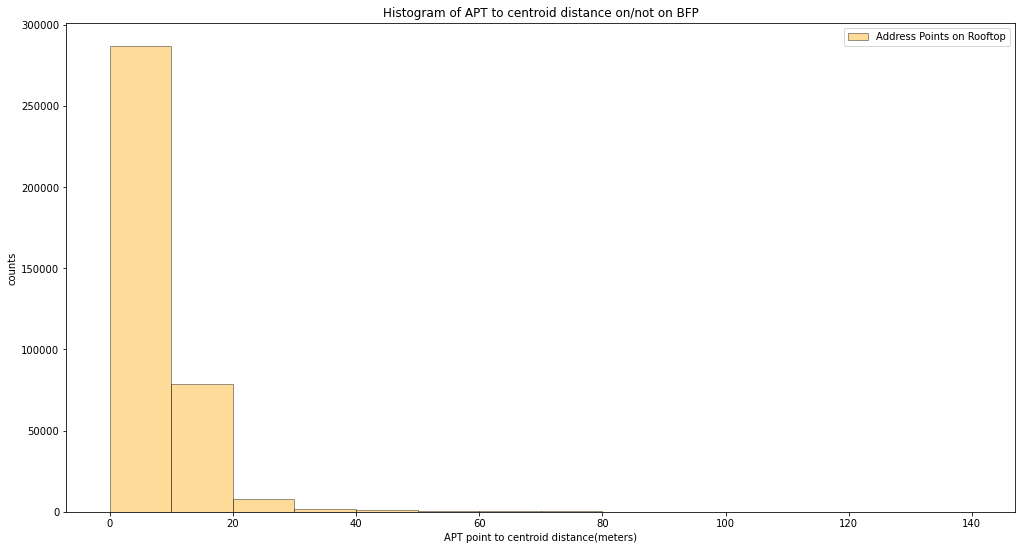

4176

In [10]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_cook['APT_to_Centroid_distance'].loc[processed_df_cook['APT_to_Centroid_distance']<150].values, bins = np.arange(0,150,10))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

### Merge Data

In [22]:
from glob import glob 
pkl_path = osp.join(data_path,state,city,'Apt_realignment')
pkl_files = glob(pkl_path+'/*/*.pkl')
print(pkl_files)


['/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Illinois/cook/Apt_realignment/APT_realign_1_bfp2parcel/APT_realigned_usa_il_cook.pkl', '/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Illinois/cook/Apt_realignment/APT_realign_2_bfp2parcel/APT_realigned_usa_uil_cook.pkl']


In [23]:
## Show single bfp within Parcel data
df_one_bfp = pd.read_pickle(pkl_files[0])
df_one_bfp = df_one_bfp.reset_index(drop=True)
print("simple scenario sahpe",df_one_bfp.shape[0])

df_two_bfp = pd.read_pickle(pkl_files[1])
df_two_bfp = df_two_bfp.reset_index(drop=True)
print(" complx scenario shape:",df_two_bfp.shape[0])

merge_df= pd.concat([df_one_bfp,df_two_bfp])
print("Merged Shape",merge_df.shape)
merge_df.to_pickle(os.path.join(pkl_path,'FinalUpdated_APT_{}_{}.pkl'.format(state,city)))


simple scenario sahpe 709024
 complx scenario shape: 377673
Merged Shape (1086697, 19)


## Michigan Wayne 

In [7]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "MI"
city = "wayne"
apt_data_path = os.path.join(data_path,state,"APT__2022_09_001_nam_usa_umx.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_26163/Parcels_26163.shp")
building_geojson = os.path.join(data_path,state,'Michigan.geojson')

In [12]:
# geojson2shpfile(building_geojson,verbose=0)

### Single BFP within a Parcel

In [13]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,
                building_shapefile=building_geojson,
                apt_shape_file=apt_data_path , 
                output_path=output_path)

processed_df_wayne = apt_preprocess.process_dataframe(bfp_count_per_parcel=1,filename='APT_realigned_usa_umx_wayne')

2022-09-02 15:48:37,793:INFO:- Processing APT's with 1 BFP-Count Per Parcel
2022-09-02 15:48:37,795:INFO:- Processing Land Parcel data and Building Footprints 
2022-09-02 15:58:01,622:INFO:- Acquiring BFP's within land Parcels 
2022-09-02 15:58:03,227:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe
2022-09-02 16:01:50,539:INFO:- saving updated Geometries ...
2022-09-02 16:03:20,160:INFO:- saving Realigned matrix..
2022-09-02 16:04:25,756:INFO:- File saved at /mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/MI/wayne/Apt_realignment/APT_realign_1_bfp2parcel/APT_realigned_usa_umx_wayne.pkl


In [14]:
print("Data Shape:",processed_df_wayne.shape)
processed_df_wayne.head()

Data Shape: (364591, 23)


,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,feat_id,iso_script,iso_lang_c,postal_cod,...,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT,updated_geometries,APT_to_Centroid_distance
0,77-018-01-0015-002,26163,100660192_209773493,"POLYGON ((-83.52600 42.43458, -83.52601 42.434...","POLYGON ((-83.52508899999999 42.434858, -83.52...","POLYGON ((-83.52509 42.43486, -83.52509 42.434...",0000554d-3200-2800-0000-00000044846e,Latn,ENG,48167,...,Westview Dr,USA,None,Dr,None,None,Westview,POINT (-83.52523619999999 42.4348473),POINT (-83.52524 42.43486),1.4
1,77-018-01-0016-000,26163,100660192_209773494,"POLYGON ((-83.52603 42.43499, -83.52607 42.435...","POLYGON ((-83.52525300000001 42.435522, -83.52...","POLYGON ((-83.52525 42.43552, -83.52552 42.435...",0000554d-3200-2800-0000-0000004c1dcb,Latn,ENG,48167,...,8 Mile Rd,USA,None,Rd,None,None,8 Mile,POINT (-83.5254626 42.4354635),POINT (-83.52540 42.43547),4.8
2,77-018-01-0003-000,26163,100660192_209773495,"POLYGON ((-83.52710 42.43315, -83.52715 42.433...","POLYGON ((-83.526023 42.433776, -83.526056 42....","POLYGON ((-83.52602 42.43378, -83.52606 42.433...",0000554d-3200-2800-0000-00000044846b,Latn,ENG,48167,...,Westview Dr,USA,None,Dr,None,None,Westview,POINT (-83.5261852 42.433816),POINT (-83.52619 42.43383),1.7
6,77-018-01-0001-002,26163,100660192_209773489,"POLYGON ((-83.52721 42.43495, -83.52724 42.435...","POLYGON ((-83.52652500000001 42.435044, -83.52...","POLYGON ((-83.52653 42.43504, -83.52653 42.435...",0000554d-3200-2800-0000-0000004c1cf4,Latn,ENG,48167,...,Westview Dr,USA,None,Dr,None,None,Westview,POINT (-83.5266215 42.4351883),POINT (-83.52661 42.43519),0.9
7,77-017-99-0002-000,26163,100660192_209773488,"POLYGON ((-83.52233 42.43575, -83.52234 42.436...","POLYGON ((-83.52209999999999 42.43592, -83.522...","POLYGON ((-83.52210 42.43592, -83.52210 42.435...",0000554d-3200-2800-0000-0000004c1f18,Latn,ENG,48167,...,8 Mile Rd,USA,None,Rd,None,None,8 Mile,POINT (-83.5220872 42.4358902),POINT (-83.52201 42.43585),7.7


In [15]:
distance_greater_than_50m = processed_df_wayne.loc[processed_df_wayne['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_wayne.shape[0])))

distance_greater_than_50m = processed_df_wayne.loc[processed_df_wayne['APT_to_Centroid_distance']<50].shape[0]
print("Data points less than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_wayne.shape[0])))

Data points greater than 50m: 0.56%
Data points less than 50m: 99.44%


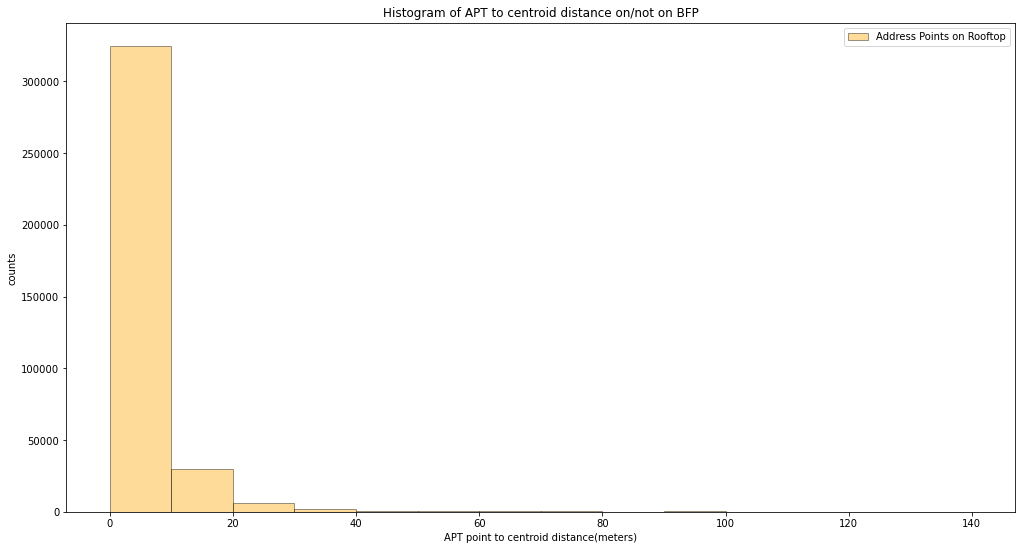

4036

In [16]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_wayne['APT_to_Centroid_distance'].loc[processed_df_wayne['APT_to_Centroid_distance']<150].values, bins = np.arange(0,150,10))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

#### Two BFP's within a Parcel 

In [17]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,
                building_shapefile=building_geojson,
                apt_shape_file=apt_data_path , 
                output_path=output_path)

processed_df_wayne = apt_preprocess.process_dataframe(bfp_count_per_parcel=2,filename='APT_realigned_usa_umx_wayne')


2022-09-02 16:04:33,026:INFO:- Processing APT's with 2 BFP-Count Per Parcel
2022-09-02 16:04:33,028:INFO:- Processing Land Parcel data and Building Footprints 
2022-09-02 16:13:26,815:INFO:- Acquiring BFP's within land Parcels 
2022-09-02 16:13:28,270:INFO:- Processing Anchor-Points data over Parcel-Building Geo-Dataframe
2022-09-02 16:32:47,994:INFO:- saving updated Geometries ...
2022-09-02 16:33:08,635:INFO:- saving Realigned matrix..
2022-09-02 16:33:52,946:INFO:- File saved at /mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/MI/wayne/Apt_realignment/APT_realign_2_bfp2parcel/APT_realigned_usa_umx_wayne.pkl


In [18]:
print(processed_df_wayne.shape[0])
processed_df_wayne.head(10)

236463


,PRCLDMPID,building_roi,APT,feat_id,iso_script,iso_lang_c,postal_cod,house_numb,state_prov,locality,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,geometry,updated_geometries,APT_to_Centroid_distance
0,100660192_209773476,"POLYGON ((-83.55066600000001 42.423966, -83.55...",POINT (-83.5491403 42.4239452),0000554d-3200-2800-0000-0000004bf8ac,Latn,ENG,48167,9166,MI,Northville,Napier Rd,USA,None,Rd,None,None,Napier,"POLYGON ((-83.55132 42.42384, -83.55133 42.424...",POINT (-83.55059511391239 42.4239232004446),119.4
1,100660192_209773477,"POLYGON ((-83.55078399999999 42.423575, -83.55...",POINT (-83.5508421 42.4236277),0000554d-3200-2800-0000-0000004bf76c,Latn,ENG,48167,9140,MI,Northville,Napier Rd,USA,None,Rd,None,None,Napier,"POLYGON ((-83.55130 42.42349, -83.55132 42.423...",POINT (-83.55085612130175 42.42364430440186),2.1
2,100660192_209773491,"POLYGON ((-83.524709 42.433685, -83.52475 42.4...",POINT (-83.52479169999999 42.4337535),0000554d-3200-2800-0000-00000044846c,Latn,ENG,48167,20390,MI,Northville,Westview Dr,USA,None,Dr,None,None,Westview,"POLYGON ((-83.52504 42.43344, -83.52506 42.433...",POINT (-83.52479404102435 42.43377457469753),2.3
3,100660192_209773497,"POLYGON ((-83.52581600000001 42.432284, -83.52...",POINT (-83.5257277 42.4323723),0000554d-3200-2800-0000-000000448469,Latn,ENG,48167,20241,MI,Northville,Westview Dr,USA,None,Dr,None,None,Westview,"POLYGON ((-83.52702 42.43176, -83.52706 42.432...",POINT (-83.52573094462173 42.43238866758083),1.8
4,100660192_209773503,"POLYGON ((-83.523758 42.431912, -83.523878 42....",POINT (-83.5237703 42.431792),0000554d-3200-2800-0000-0000004487c9,Latn,ENG,48167,20120,MI,Northville,Westview Dr,USA,None,Dr,None,None,Westview,"POLYGON ((-83.52397 42.43133, -83.52401 42.431...",POINT (-83.52377399999999 42.4318055),1.5
5,100660192_209773524,"POLYGON ((-83.533033 42.425062, -83.53269 42.4...",POINT (-83.5328943 42.4251275),0000554d-3200-2800-0000-0000004bfcdb,Latn,ENG,48167,49560,MI,Northville,7 Mile Rd,USA,None,Rd,None,None,7 Mile,"POLYGON ((-83.53330 42.42471, -83.53331 42.425...",POINT (-83.5328706051414 42.42513484116814),2.1
6,100660192_209773525,"POLYGON ((-83.533818 42.424511, -83.533987 42....",POINT (-83.53383669999999 42.4243965),0000554d-3200-2800-0000-0000004bf849,Latn,ENG,48167,19400,MI,Northville,Apple Blossom,USA,None,None,None,None,Apple Blossom,"POLYGON ((-83.53447 42.42329, -83.53460 42.424...",POINT (-83.53384777425478 42.42440597802841),1.3
7,100660192_209773534,"POLYGON ((-83.519004 42.422808, -83.5190170000...",POINT (-83.519054 42.4228451),0000554d-3200-2800-0000-0000004bf727,Latn,ENG,48167,47900,MI,Northville,7 Mile Rd,USA,None,Rd,None,None,7 Mile,"POLYGON ((-83.51930 42.42262, -83.51943 42.424...",POINT (-83.51907328827794 42.42285960832354),2.2
8,100660192_209773573,"POLYGON ((-83.511014 42.431829, -83.510964 42....",POINT (-83.51084659999999 42.4318247),0000554d-3200-2800-0000-0000004c11c5,Latn,ENG,48167,20000,MI,Northville,Beck Rd,USA,None,Rd,None,None,Beck,"POLYGON ((-83.51102 42.43122, -83.51212 42.431...",POINT (-83.51085117136535 42.43184085124676),1.8
9,100660192_209773578,"POLYGON ((-83.50863 42.433507, -83.50855799999...",POINT (-83.5085093 42.4334102),0000554d-3200-2800-0000-0000004488c3,Latn,ENG,48167,20507,MI,Northville,Woodbend Dr,USA,None,Dr,None,None,Woodbend,"POLYGON ((-83.50884 42.43318, -83.50894 42.433...",POINT (-83.50851418412574 42.43342639921051),1.8


In [19]:
distance_greater_than_50m = processed_df_wayne.loc[processed_df_wayne['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_wayne.shape[0])))

distance_greater_than_50m = processed_df_wayne.loc[processed_df_wayne['APT_to_Centroid_distance']<50].shape[0]
print("Data points less than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_wayne.shape[0])))


Data points greater than 50m: 0.41%
Data points less than 50m: 99.59%


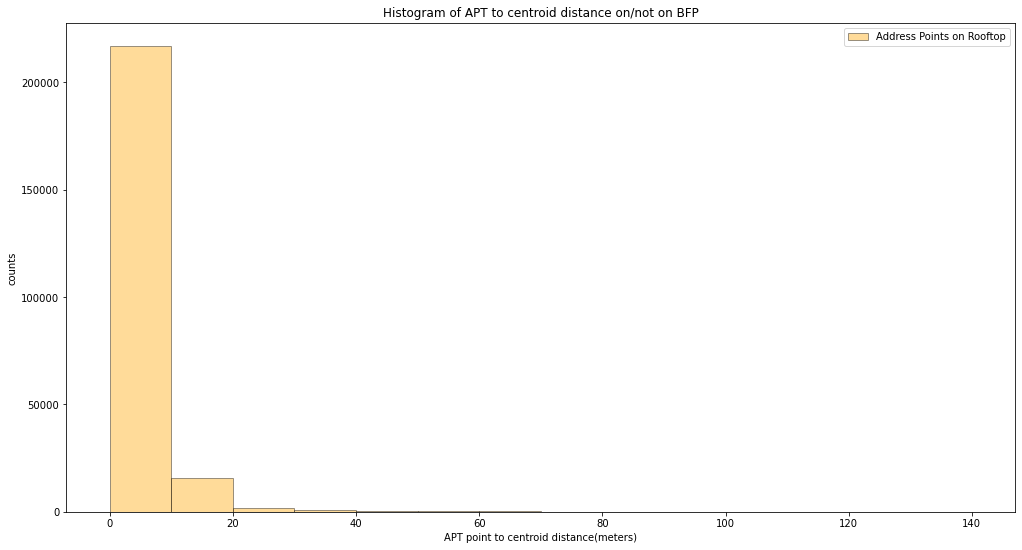

4026

In [20]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_wayne['APT_to_Centroid_distance'].loc[processed_df_wayne['APT_to_Centroid_distance']<150].values, bins = np.arange(0,150,10))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

### Merge both data 

In [17]:
from glob import glob 
import os
import os.path as osp 
pkl_path = osp.join(data_path,state,city,'Apt_realignment')
pkl_files = glob(pkl_path+'/*/*.pkl')
print(pkl_files)

['/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/MI/wayne/Apt_realignment/APT_realign_1_bfp2parcel/APT_realigned_usa_umx_wayne.pkl', '/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/MI/wayne/Apt_realignment/APT_realign_2_bfp2parcel/APT_realigned_usa_umx_wayne.pkl']


In [18]:

## Show single bfp within Parcel data
df_one_bfp = pd.read_pickle(pkl_files[0])
df_one_bfp = df_one_bfp.reset_index(drop=True)
print("simple scenario sahpe",df_one_bfp.shape[0])

df_two_bfp = pd.read_pickle(pkl_files[1])
df_two_bfp = df_two_bfp.reset_index(drop=True)
print(" complx scenario shape:",df_two_bfp.shape[0])

merge_df= pd.concat([df_one_bfp,df_two_bfp])
print("Merged Shape",merge_df.shape)
merge_df.to_pickle(os.path.join(pkl_path,'FinalUpdated_APT_{}_{}.pkl'.format(state,city)))

simple scenario sahpe 364591
 complx scenario shape: 236463
Merged Shape (601054, 19)


## Dallas Texas 

In [25]:
import os
import shapely
import numpy as np
import sys 
import pycoredb 
import pandas as pd 
import gc
from shapely import wkt
from matplotlib import pyplot as plt
from shapely.geometry import Point,mapping,Polygon,box,MultiPoint
import geopandas as gpd 
import seaborn as sns 
 
# for parallelization
sys.path.append('/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/APT-Realignment/src/apt_realignment')
from process_geometries import ProcessGeometricData  as ProcessAPT_data
from utils.haversine_distance import get_distance

data_path  = "/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data"
state = "Texas"
city = "Dallas"
apt_data_path = os.path.join(data_path,state,"APT_2022_09_000_nam_usa_utx.shp" )
parcel_path = os.path.join(data_path,state,city,"Parcels_48113/Parcels_48113.shp")
building_geojson = os.path.join(data_path,state,'Texas.geojson')

### Single BFP within Parcel 

In [2]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,
                building_shapefile=building_geojson,
                apt_shape_file=apt_data_path , 
                output_path=output_path)

processed_df_dallas = apt_preprocess.process_dataframe(bfp_count_per_parcel=1,filename='APT_realigned_usa_utx_dallas')
processed_df_dallas.head(10)

2022-09-05 08:11:44,860:INFO:- Processing APT's with 1 BFP-Count Per Parcel
2022-09-05 08:11:44,861:INFO:- Processing Land Parcel data and Building Footprints 
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -96.822597945584874 32.792290560973626 at -96.822597945584874 32.792290560973626
ERROR:root:error for POLYGON ((-96.82235 32.792651, -96.822633 32.792782, -96.822717 32.792653, -96.822503 32.792554, -96.822515 32.792536, -96.82274200000001 32.792641, -96.82286999999999 32.792446, -96.822585 32.792314, -96.82252099999999 32.792411, -96.82250999999999 32.792406, -96.82235 32.792651)),POLYGON ((-96.82259794558487 32.79229056097363, -96.82259167428218 32.79229905352135, -96.8228620343875 32.79245170268983, -96.82286664060364 32.79244580754849, -96.82273150946465 32.79236915178497, -96.82259794558487 32.79229056097363, -96.8227448261717 32.7923765406119, -96.82289358655891 32.79246018298879, -96.82275556663321 32.79264663647488, -96.8224520335861 32.7

,APN,FIPS,PRCLDMPID,geometry,building_geometry,building_roi,feat_id,iso_script,iso_lang_c,postal_cod,...,street_nam,country_co,prefix,suffix,predir,postdir,sn_body,APT,updated_geometries,APT_to_Centroid_distance
15,180016900E34R0000,48113,100660192_213642851,"POLYGON ((-96.95425 32.97523, -96.95514 32.975...","POLYGON ((-96.95498600000001 32.975508, -96.95...","POLYGON ((-96.95499 32.97551, -96.95483 32.975...",00005554-3100-2800-0000-0000000b9baa,Latn,ENG,75019,...,Creek Xing,USA,None,Xing,None,None,Creek,POINT (-96.95424800000001 32.975479),POINT (-96.95491 32.97558),62.6
16,180024500D14R0000,48113,100660192_213642852,"POLYGON ((-96.95443 32.97467, -96.95444 32.974...","POLYGON ((-96.954466 32.974852, -96.95439 32.9...","POLYGON ((-96.95447 32.97485, -96.95439 32.974...",00005554-3100-2800-0000-0000000b9ba8,Latn,ENG,75019,...,Basilwood Dr,USA,None,Dr,None,None,Basilwood,POINT (-96.954144 32.974875),POINT (-96.95435 32.97484),19.8
17,180016900E32R0000,48113,100660192_213642850,"POLYGON ((-96.95307 32.97581, -96.95513 32.975...","POLYGON ((-96.954796 32.975915, -96.954795 32....","POLYGON ((-96.95480 32.97592, -96.95480 32.975...",00005554-3100-2800-0000-0000000b9bb0,Latn,ENG,75019,...,Creek Xing,USA,None,Xing,None,None,Creek,POINT (-96.9541 32.975973),POINT (-96.95489 32.97600),73.8
18,180016900E31R0000,48113,100660192_213642849,"POLYGON ((-96.95512 32.97611, -96.95512 32.976...","POLYGON ((-96.955016 32.97612, -96.954829 32.9...","POLYGON ((-96.95502 32.97612, -96.95483 32.976...",00005554-3100-2800-0000-0000000b9bb1,Latn,ENG,75019,...,Creek Xing,USA,None,Xing,None,None,Creek,POINT (-96.954126 32.976269),POINT (-96.95492 32.97620),74.3
19,180016900E33R0000,48113,100660192_213642848,"POLYGON ((-96.95334 32.97552, -96.95515 32.975...","POLYGON ((-96.954798 32.975877, -96.9550189999...","POLYGON ((-96.95480 32.97588, -96.95502 32.975...",00005554-3100-2800-0000-0000000b9baf,Latn,ENG,75019,...,Creek Xing,USA,None,Xing,None,None,Creek,POINT (-96.95411 32.97572),POINT (-96.95489 32.97581),73.8
22,180016900E30R0000,48113,100660192_213642845,"POLYGON ((-96.95513 32.97631, -96.95515 32.976...","POLYGON ((-96.95491699999999 32.97633, -96.954...","POLYGON ((-96.95492 32.97633, -96.95477 32.976...",00005554-3100-2800-0000-0000000b9bb8,Latn,ENG,75019,...,Creek Xing,USA,None,Xing,None,None,Creek,POINT (-96.954155 32.976532),POINT (-96.95488 32.97641),68.8
28,180060500A0080000,48113,100660192_213642863,"POLYGON ((-96.98691 32.97108, -96.98716 32.971...","POLYGON ((-96.986937 32.971324, -96.987138 32....","POLYGON ((-96.98694 32.97132, -96.98714 32.971...",00005554-3100-2800-0000-0000000b89be,Latn,ENG,75019,...,Suzanne Way,USA,None,Way,None,None,Suzanne,POINT (-96.98703 32.971245),POINT (-96.98704 32.97123),1.7
29,180024500D0260000,48113,100660192_213642839,"POLYGON ((-96.95576 32.97268, -96.95577 32.972...","POLYGON ((-96.95545300000001 32.972683, -96.95...","POLYGON ((-96.95545 32.97268, -96.95546 32.972...",00005554-3100-2800-0000-0000000b9aea,Latn,ENG,75019,...,Hollywood Dr,USA,None,Dr,None,None,Hollywood,POINT (-96.955529 32.972805),POINT (-96.95559 32.97275),7.9
33,180060500C0210000,48113,100660192_213642868,"POLYGON ((-96.98583 32.97117, -96.98624 32.971...","POLYGON ((-96.986155 32.971345, -96.986158 32....","POLYGON ((-96.98615 32.97134, -96.98616 32.971...",00005554-3100-2800-0000-0000000b89d7,Latn,ENG,75019,...,Woodcrest Ln,USA,None,Ln,None,None,Woodcrest,POINT (-96.98603 32.971273),POINT (-96.98605 32.97127),1.4
34,180060500C0220000,48113,100660192_213642869,"POLYGON ((-96.98582 32.97136, -96.98623 32.971...","POLYGON ((-96.986026 32.971383, -96.986025 32....","POLYGON ((-96.98603 32.97138, -96.98602 32.971...",00005554-3100-2800-0000-0000000b8a0b,Latn,ENG,75019,...,Woodcrest Ln,USA,None,Ln,None,None,Woodcrest,POINT (-96.98602099999999 32.971468),POINT (-96.98606 32.97147),3.4


In [3]:
distance_greater_than_50m = processed_df_dallas.loc[processed_df_dallas['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_dallas.shape[0])))

distance_greater_than_50m = processed_df_dallas.loc[processed_df_dallas['APT_to_Centroid_distance']<50].shape[0]
print("Data points less than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_dallas.shape[0])))


Data points greater than 50m: 0.92%
Data points less than 50m: 99.07%


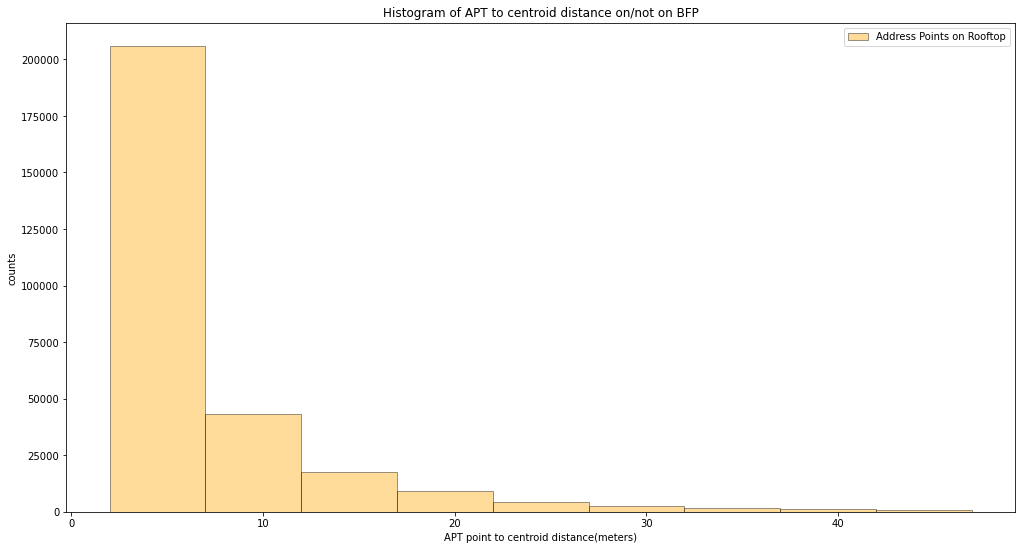

6

In [4]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_dallas['APT_to_Centroid_distance'].loc[processed_df_dallas['APT_to_Centroid_distance']<50].values, bins = np.arange(2,50,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

### Two BFP within Parcel 

In [ ]:
output_path = os.path.join(data_path,state,city,'Apt_realignment') 
apt_preprocess = ProcessAPT_data(parcel_shapefile=parcel_path,building_shapefile=building_geojson,
                                    apt_shape_file=apt_data_path , output_path=output_path)

processed_df_dallas = apt_preprocess.process_dataframe(bfp_count_per_parcel=2,filename='APT_realigned_usa_utx_dallas')
processed_df_dallas.head(10)

In [ ]:
distance_greater_than_50m = processed_df_dallas.loc[processed_df_dallas['APT_to_Centroid_distance']>50].shape[0]
print("Data points greater than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_dallas.shape[0])))

distance_greater_than_50m = processed_df_dallas.loc[processed_df_dallas['APT_to_Centroid_distance']<50].shape[0]
print("Data points less than 50m: {:.2f}%".format(100*(distance_greater_than_50m/processed_df_dallas.shape[0])))


In [ ]:
fig, ax = plt.subplots(figsize=(17,9))

ax.set_title("Histogram of APT to centroid distance on/not on BFP")
ax.set_xlabel("APT point to centroid distance(meters)")
ax.set_ylabel("counts")

frqTrue, edgesTrue = np.histogram(processed_df_dallas['APT_to_Centroid_distance'].loc[processed_df_dallas['APT_to_Centroid_distance']<50].values, bins = np.arange(2,50,5))
p1 = ax.bar(edgesTrue[:-1], frqTrue, width=np.diff(edgesTrue), edgecolor="black", align="edge",alpha=0.4,label='Address Points on Rooftop',color='orange')

plt.legend()
plt.show()
gc.collect()

### Merge Data

In [26]:
from glob import glob 
pkl_path = osp.join(data_path,state,city,'Apt_realignment')
pkl_files = glob(pkl_path+'/*/*.pkl')
print(pkl_files)

['/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Texas/Dallas/Apt_realignment/APT_realign_1_bfp2parcel/APT_realigned_usa_utx_dallas.pkl', '/mnt/c/Users/tandon/OneDrive - TomTom/Desktop/tomtom/Workspace/01_Rooftop_accuracy/BFP_Analysis_USA/data/data/Texas/Dallas/Apt_realignment/APT_realign_2_bfp2parcel/APT_realigned_usa_utx_dallas.pkl']


In [27]:

## Show single bfp within Parcel data
df_one_bfp = pd.read_pickle(pkl_files[0])
df_one_bfp = df_one_bfp.reset_index(drop=True)
print("simple scenario sahpe",df_one_bfp.shape[0])

df_two_bfp = pd.read_pickle(pkl_files[1])
df_two_bfp = df_two_bfp.reset_index(drop=True)
print(" complx scenario shape:",df_two_bfp.shape[0])

merge_df= pd.concat([df_one_bfp,df_two_bfp])
print("Merged Shape",merge_df.shape)
merge_df.to_pickle(os.path.join(pkl_path,'FinalUpdated_APT_{}_{}.pkl'.format(state,city)))

simple scenario sahpe 393782
 complx scenario shape: 172430
Merged Shape (566212, 19)
